In [280]:
import math
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from IPython.display import display
import math
%matplotlib inline

## Neural Networks

In [282]:
class Value:
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label

    def __repr__(self):
        return f'Value(data={self.data})'

    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')
        
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward
        return out

    def __radd__(self, other):
        return self + other

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad

        out._backward = _backward
        return out

    def __rmul__(self, other):  # Fallback in the case of int * Value(x)
        return self * other

    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only support int/float powers"
        out = Value(self.data**other, (self,), f'**{other}')
        def _backward():
            self.grad += other * (self.data ** (other-1)) * out.grad
        out._backward = _backward
        return out

    def __truediv__(self, other):
        return self * other**-1

    def __neg__(self):  # -self
        return self * -1

    def __sub__(self, other):  # self - other
        return self + (-other)

    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)

        out = Value(t, (self, ), _op='tanh')

        def _backward():
            self.grad += (1 - t**2) * out.grad

        out._backward = _backward
        return out

    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self,), 'exp')
        def _backward():
            self.grad += out.data * out.grad
        out._backward = _backward
        return out

    def backward(self):
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)

        self.grad = 1.0
        
        for node in reversed(topo):
            node._backward()
        

In [283]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)
  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)
  return display(dot)

## A simple neural network

In [285]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'
o.backward()

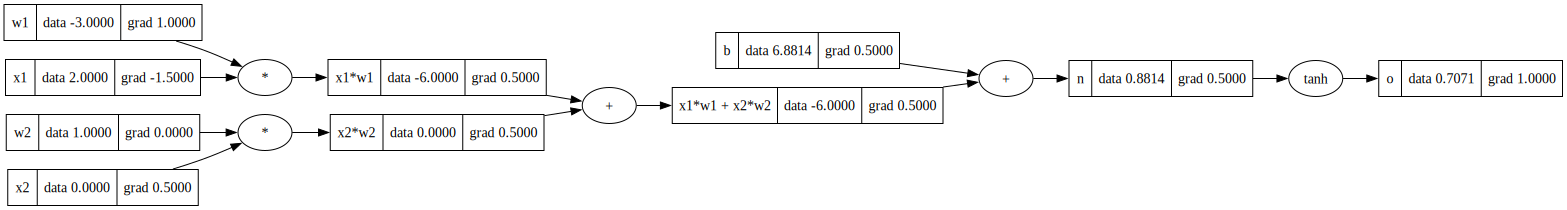

In [286]:
draw_dot(o)

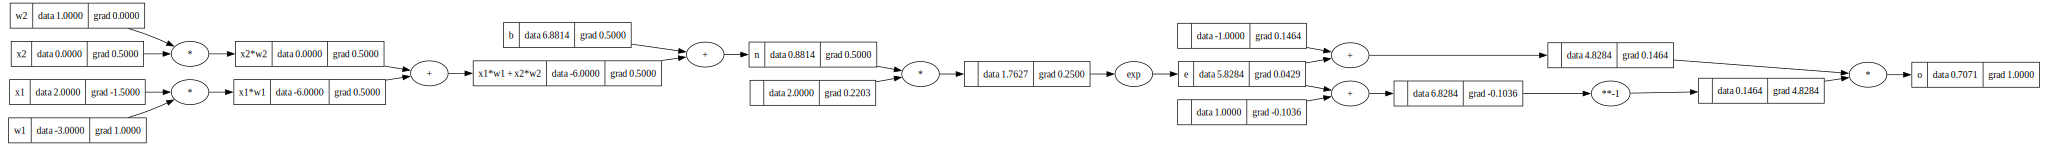

In [287]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
# -----
e = (2*n).exp(); e.label = 'e'
o = (e -1) / (e + 1); o.label = 'o'
# -----
o.backward()
draw_dot(o)

## Implementation of similar computation using pytorch

In [289]:
import torch

In [290]:
x1 = torch.Tensor([2.0]).double()
x2 = torch.Tensor([0.0]).double()
w1 = torch.Tensor([-3.0]).double()
w2 = torch.Tensor([1.0]).double()
b = torch.Tensor([6.8813735870195432]).double()

x1.requires_grad = True
x2.requires_grad = True
w1.requires_grad = True
w2.requires_grad = True
b.requires_grad = True

n = x1*w1 + x2*w2 + b
o = torch.tanh(n)
o.data.item()

0.7071066904050358

In [291]:
o.backward()

In [292]:
print('----')
print('x2', x2.grad.item())
print('x1', x1.grad.item())
print('w2', w2.grad.item())
print('w1', w1.grad.item())

----
x2 0.5000001283844369
x1 -1.5000003851533106
w2 0.0
w1 1.0000002567688737


## Implementing neural networks from a single neuron

In [294]:
import random 

# Define neuron
class Neuron:

    def __init__(self, nin):
        self.w = [Value(random.uniform(-1, 1)) for _ in range (nin)]
        self.b = Value(random.uniform(-1,1))

    def __call__(self, x):
        # w * x + b
        act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
        out = act.tanh()
        return out

    def parameters(self):
        return self.w + [self.b]

# Define layer (a list of neurons)
class Layer:
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]

    def __call__(self, x):
        out = [n(x) for n in self.neurons]
        return out[0] if len(out) == 1 else out
    
    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]
        
# Define multi-level perceptron
class MLP:
    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]

    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x) 
        return x

In [295]:
x = [2.0, 3.0, -1]
n = MLP(3, [4, 4, 1])
n(x)

Value(data=0.4832958363627717)

In [296]:
n.parameters()

[Value(data=0.13150112231830158),
 Value(data=-0.7005709558220039),
 Value(data=-0.6515667551713413),
 Value(data=0.5556497623740511),
 Value(data=-0.8281898435233321),
 Value(data=-0.2735579388047926),
 Value(data=0.47952949350958285),
 Value(data=-0.9193572318811283),
 Value(data=0.13040405832466728),
 Value(data=-0.8119303861605938),
 Value(data=-0.7930962850738201),
 Value(data=-0.12441518136982843),
 Value(data=0.586210276942543),
 Value(data=-0.0972169839427639),
 Value(data=0.643329694241576),
 Value(data=-0.19169093438768736),
 Value(data=0.30954151964106047),
 Value(data=-0.2337793778298083),
 Value(data=-0.9431530527053329),
 Value(data=-0.016115139041846138),
 Value(data=0.05025516319530676),
 Value(data=0.7467188261883229),
 Value(data=-0.907804573295081),
 Value(data=0.5427339855162072),
 Value(data=0.9849193224734416),
 Value(data=0.044086486829203464),
 Value(data=-0.6483114292471939),
 Value(data=-0.619133257180609),
 Value(data=-0.33321843076298996),
 Value(data=-0.761

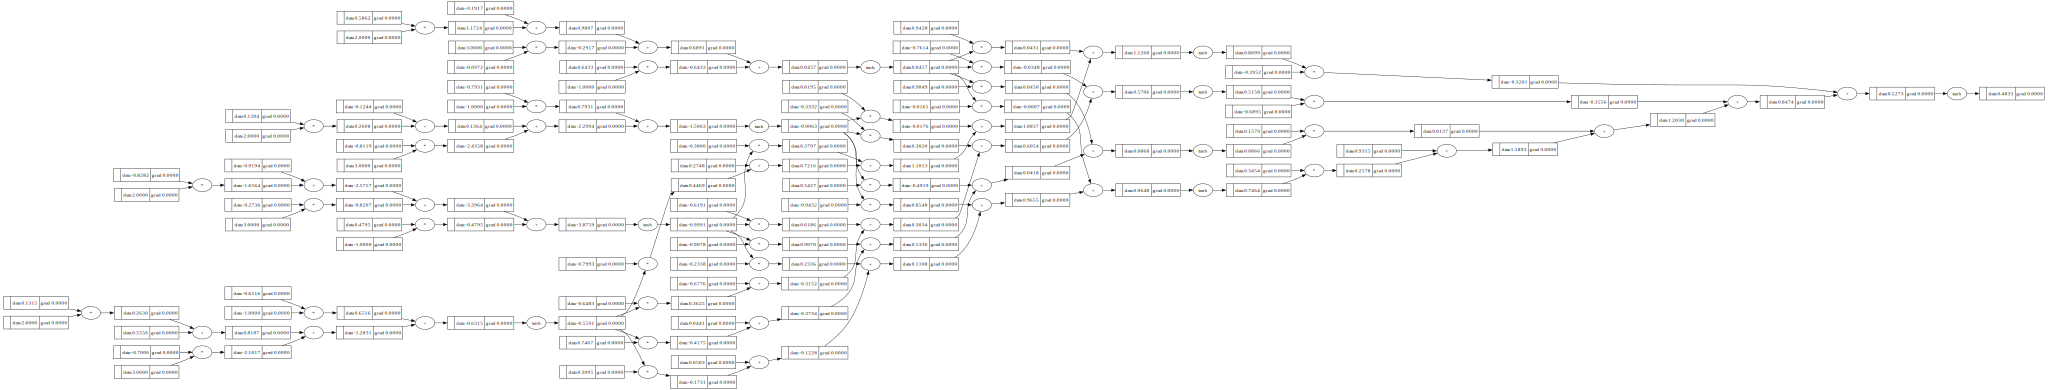

In [297]:
draw_dot(n(x))

In [298]:
xs = [
    [2.0, 3.0, -1,0],
    [3.0, -1.0, 0.5],
    [.5, 1.0, 1.0],
    [1.0, 1.0, -1.0]
]
ys = [1., -1., -1., 1.]  # desired targets

In [299]:
ypred = [n(x) for x in xs]
ypred

[Value(data=0.4832958363627717),
 Value(data=0.8920941252512272),
 Value(data=0.6648206961465811),
 Value(data=0.8786689937038427)]

We can calculate the amount of change we want to see in all the predictions using a single variable __loss__
There are several methods of doing this but we're going to implement the mean squared error method to calculate and minimize the loss

In [301]:
loss = sum([(yout - ygt)**2 for ygt, yout in zip(ys, ypred)])
loss

Value(data=6.633352534937079)

In [302]:
loss.backward()

In [303]:
n.layers[0].neurons[0].w[0].grad

-0.1278979498843616

In [304]:
n.layers[0].neurons[0].w[0].data

0.13150112231830158

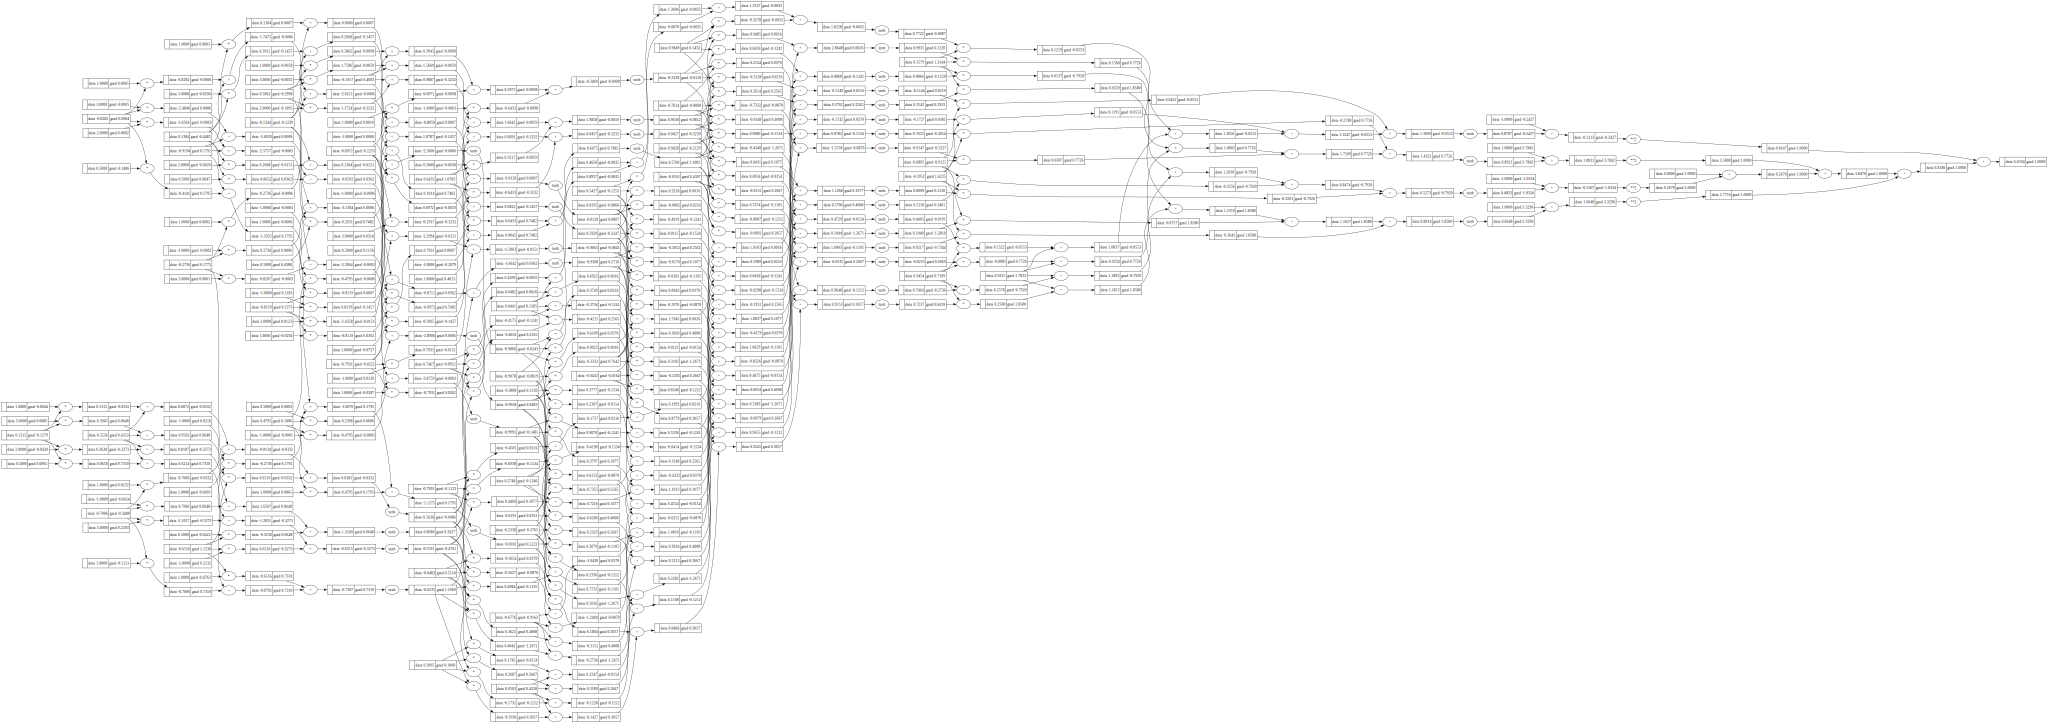

In [305]:
draw_dot(loss)

In [306]:
for p in n.parameters():
    p.data += -0.01 * p.grad

In [307]:
# Predict and recalculate loss
ypred = [n(x) for x in xs]

loss = sum([(yout - ygt)**2 for ygt, yout in zip(ys, ypred)])
loss

Value(data=6.47132153124561)

In [308]:
loss.backward()

In [309]:
ypred

[Value(data=0.458438812575991),
 Value(data=0.8788169206990692),
 Value(data=0.6221835184090333),
 Value(data=0.8711565965271608)]

The values are now quite close to the expected answers, now we should be careful not to overstemp past the correct parameters

In [311]:
for p in n.parameters():
    p.data += -0.01 * p.grad

# Predict and recalculate loss
ypred = [n(x) for x in xs]

loss = sum([(yout - ygt)**2 for ygt, yout in zip(ys, ypred)])
print('loss', loss)

loss.backward()

ypred

loss Value(data=6.114265352339241)


[Value(data=0.40298892145793547),
 Value(data=0.8467390804794491),
 Value(data=0.5251411872479788),
 Value(data=0.8539101234615275)]

In [312]:
for p in n.parameters():
    p.data += -0.01 * p.grad

# Predict and recalculate loss
ypred = [n(x) for x in xs]

loss = sum([(yout - ygt)**2 for ygt, yout in zip(ys, ypred)])
print('loss', loss)

loss.backward()

ypred

loss Value(data=5.522338193767192)


[Value(data=0.3074519598646935),
 Value(data=0.7814188889978769),
 Value(data=0.3555453075801969),
 Value(data=0.8217892626949294)]

Values are almost perfectly in sync with the ground true answers, here are the parameters when a loss of 0.04 is achieved

In [314]:
n.parameters()

[Value(data=0.14042229648366295),
 Value(data=-0.6755120726834772),
 Value(data=-0.7218373062568367),
 Value(data=0.5297900758365626),
 Value(data=-0.833962828334554),
 Value(data=-0.2848651250925638),
 Value(data=0.4680008311943602),
 Value(data=-0.9307846157692594),
 Value(data=0.15855440503529022),
 Value(data=-0.8205136289224199),
 Value(data=-0.7916446301417096),
 Value(data=-0.1165984480945099),
 Value(data=0.6039848259440568),
 Value(data=-0.08450276648425763),
 Value(data=0.578042331441086),
 Value(data=-0.21691932291402727),
 Value(data=0.30322026939795826),
 Value(data=-0.20979196312271475),
 Value(data=-0.942521358699005),
 Value(data=-0.04329927403653101),
 Value(data=0.02256131526861886),
 Value(data=0.7522689965335562),
 Value(data=-0.9029453267082487),
 Value(data=0.5501300995248724),
 Value(data=0.9766778972417318),
 Value(data=0.036388289256276574),
 Value(data=-0.6802051013361302),
 Value(data=-0.6607551989216547),
 Value(data=-0.3796921245726349),
 Value(data=-0.7124

Continueing our run might overstep the correct answers

In [316]:
for p in n.parameters():
    p.data += -0.01 * p.grad

# Predict and recalculate loss
ypred = [n(x) for x in xs]

loss = sum([(yout - ygt)**2 for ygt, yout in zip(ys, ypred)])
print('loss', loss)

loss.backward()

ypred

loss Value(data=4.715378108772001)


[Value(data=0.16783911599932352),
 Value(data=0.6522830704126776),
 Value(data=0.11264223665889964),
 Value(data=0.7657474005660798)]

In [317]:
for p in n.parameters():
    p.data += -0.01 * p.grad

# Predict and recalculate loss
ypred = [n(x) for x in xs]

loss = sum([(yout - ygt)**2 for ygt, yout in zip(ys, ypred)])
print('loss', loss)

loss.backward()

ypred

loss Value(data=3.7893740981335884)


[Value(data=0.006918716727677162),
 Value(data=0.40841936292503406),
 Value(data=-0.15588270360889456),
 Value(data=0.6729150706330281)]

In [318]:
for p in n.parameters():
    p.data += -0.01 * p.grad

# Predict and recalculate loss
ypred = [n(x) for x in xs]

loss = sum([(yout - ygt)**2 for ygt, yout in zip(ys, ypred)])
print('loss', loss)

loss.backward()

ypred

loss Value(data=2.8624819396307606)


[Value(data=-0.10548373389825588),
 Value(data=0.01996428523953923),
 Value(data=-0.3810418870204548),
 Value(data=0.5342196172768466)]

In [319]:
for p in n.parameters():
    p.data += -0.01 * p.grad

# Predict and recalculate loss
ypred = [n(x) for x in xs]

loss = sum([(yout - ygt)**2 for ygt, yout in zip(ys, ypred)])
print('loss', loss)

loss.backward()

ypred

loss Value(data=2.123004035398314)


[Value(data=-0.07915903306224392),
 Value(data=-0.39904455604230793),
 Value(data=-0.5288035904254577),
 Value(data=0.3874264821752821)]

In [320]:
for p in n.parameters():
    p.data += -0.01 * p.grad

# Predict and recalculate loss
ypred = [n(x) for x in xs]

loss = sum([(yout - ygt)**2 for ygt, yout in zip(ys, ypred)])
print('loss', loss)

loss.backward()

ypred

loss Value(data=1.3172918430323306)


[Value(data=0.18661178678828952),
 Value(data=-0.6802410931218074),
 Value(data=-0.5922772833090032),
 Value(data=0.3777396964237812)]

In [321]:
for p in n.parameters():
    p.data += -0.01 * p.grad

# Predict and recalculate loss
ypred = [n(x) for x in xs]

loss = sum([(yout - ygt)**2 for ygt, yout in zip(ys, ypred)])
print('loss', loss)

loss.backward()

ypred

loss Value(data=0.5083845884137403)


[Value(data=0.7137521405081004),
 Value(data=-0.8282581266956771),
 Value(data=-0.5427616269520842),
 Value(data=0.5665434848609807)]

As can be seen, loss now starts to increase

In [323]:
for p in n.parameters():
    p.data += -0.01 * p.grad

# Predict and recalculate loss
ypred = [n(x) for x in xs]

loss = sum([(yout - ygt)**2 for ygt, yout in zip(ys, ypred)])
print('loss', loss)

loss.backward()

ypred

loss Value(data=0.5352426473660228)


[Value(data=0.8749557452736958),
 Value(data=-0.9077174730687775),
 Value(data=-0.3493347028354653),
 Value(data=0.7038156182123341)]

## Automating error minimization process

In [387]:
xs = [
    [2.0, 3.0, -1,0],
    [3.0, -1.0, 0.5],
    [.5, 1.0, 1.0],
    [1.0, 1.0, -1.0]
]
ys = [1., -1., -1., 1.]

x = [2.0, 3.0, -1]
n = MLP(3, [4, 4, 1])
n(x)

for index in range(25):
    ypred = [n(x) for x in xs]

    loss = sum((yout - ygt)**2 for yout, ygt in zip(ypred, ys))

    for param in n.parameters():
        param.data += -0.01 * param.grad

    loss.backward()
    print(ypred, loss.data)

[Value(data=0.09051344211848193), Value(data=0.442864139967009), Value(data=-0.1280523416018263), Value(data=0.30578877150981537)] 4.151244674117818
[Value(data=0.09051344211848193), Value(data=0.442864139967009), Value(data=-0.1280523416018263), Value(data=0.30578877150981537)] 4.151244674117818
[Value(data=0.18110308462206648), Value(data=0.394048802725289), Value(data=-0.1619972978749384), Value(data=0.35285824127411963)] 3.7350052070510364
[Value(data=0.35608143977889417), Value(data=0.2873196756725437), Value(data=-0.2281545030546016), Value(data=0.4426349513011518)] 2.9782243282368435
[Value(data=0.5354440297186502), Value(data=0.09582522935161465), Value(data=-0.33373086245217876), Value(data=0.54111223730911)] 2.0711377252037333
[Value(data=0.6467980673711503), Value(data=-0.20872168756225376), Value(data=-0.48579233738974487), Value(data=0.6064537084154358)] 1.1701611768541471
[Value(data=0.691133242987579), Value(data=-0.5652893810871541), Value(data=-0.6616604970165308), Val

As can be seen in the above scenario we get very very very close to the answer with really really really close precision. Now we need to implement zero grad functionality so that we may flush out previous grads from past iteration

In [403]:
xs = [
    [2.0, 3.0, -1,0],
    [3.0, -1.0, 0.5],
    [.5, 1.0, 1.0],
    [1.0, 1.0, -1.0]
]
ys = [1., -1., -1., 1.]

x = [2.0, 3.0, -1]
n = MLP(3, [4, 4, 1])
n(x)

for index in range(1000):
    ypred = [n(x) for x in xs]

    loss = sum((yout - ygt)**2 for yout, ygt in zip(ypred, ys))

    for param in n.parameters():
        param.grad = 0.0
        
    loss.backward()

    for param in n.parameters():
        param.data += -0.05 * param.grad
        
    print(f'{index}. {ypred, loss.data}')

0. ([Value(data=-0.8941346570826912), Value(data=-0.8154712043278337), Value(data=-0.7979028441388125), Value(data=-0.887040446170587)], 7.223561881484853)
1. ([Value(data=-0.8218890498242006), Value(data=-0.7308869831710401), Value(data=-0.7093388609491004), Value(data=-0.8126996687239865)], 6.762065512442529)
2. ([Value(data=-0.6443289236595252), Value(data=-0.5542411724907232), Value(data=-0.5305230622222609), Value(data=-0.6342817828596958)], 5.793804082377966)
3. ([Value(data=-0.22387854895089715), Value(data=-0.20908681849013502), Value(data=-0.1921983727218985), Value(data=-0.22443648860992169)], 4.275210546940754)
4. ([Value(data=0.14834027941775546), Value(data=-0.021659272255009267), Value(data=0.012283707329029602), Value(data=0.11955978323798258)], 3.4823681386425775)
5. ([Value(data=0.20041171085949636), Value(data=-0.24582646300782576), Value(data=-0.14907972733625424), Value(data=0.1353759899911383)], 2.6797591451438714)
6. ([Value(data=0.4445463082530535), Value(data=-0

In [405]:
xs = [
    [2.0, 3.0, -1,0],
    [3.0, -1.0, 0.5],
    [.5, 1.0, 1.0],
    [1.0, 1.0, -1.0]
]
ys = [1., -1., -1., 1.]

x = [2.0, 3.0, -1]
n = MLP(3, [4, 4, 1])

for k in range(20):
  
  # forward pass
  ypred = [n(x) for x in xs]
  loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))
  
  # backward pass
  for p in n.parameters():
    p.grad = 0.0
  loss.backward()
  
  # update
  for p in n.parameters():
    p.data += -0.1 * p.grad
  
  print(k, loss.data)
  

0 8.223885645147867
1 7.751187107461038
2 7.557546748994129
3 6.928991763434358
4 3.771306692867901
5 2.4786783438518953
6 0.7171975651141739
7 0.4227674744916541
8 0.29229468428069166
9 0.21902777931676365
10 0.17270162746602993
11 0.1411174597235506
12 0.11840571260164676
13 0.1014072381681615
14 0.08828029232274809
15 0.0778841887988811
16 0.06947791489313102
17 0.06256106713848
18 0.05678466154019771
19 0.05189859119497825
